In [234]:
# See if we have GPU access
import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

In [235]:
# Optionally set debugging
# tf.debugging.set_log_device_placement(True)
# tf.debugging.set_log_device_placement(False)

In [236]:
# Load the annotation data
from json import load
from pathlib import Path

p = (Path().resolve() / "../pose_data/annotations.json").resolve()
annotations = load(p.open())

In [237]:
# Load annotated images in the following categories
ALLOW_ALL = True
ALLOWED_CATEGORIES = ["bicycling", "running", "walking"]
#ALLOWED_JOINTS = [1, 4, 9, 12, 13] # r knee, l knee, head, r shoulder, l shoulder
ALLOWED_JOINTS= [9]


valid_imgs = []
for i in range(len(annotations["act"])):
    if ALLOW_ALL or annotations["act"][i]["cat_name"] in ALLOWED_CATEGORIES:
        valid_imgs.append(i)
print(f"Indexed {len(valid_imgs)} images with valid categories")

Indexed 24987 images with valid categories


In [238]:
# Parse it to only images with a single person visible
import numpy as np

annorect_imgs = []

#for i in range(len(valid_imgs)):
i = 0
while len(annorect_imgs) < 1000:
    i_img = valid_imgs[i]
    annolist = annotations["annolist"][i_img]
    annorects = annolist["annorect"]
    if isinstance(annorects, dict): # Only one annorect (one person)
        if "annopoints" in annorects.keys():
            point = annorects["annopoints"]["point"]
            # Check that every joint we care about is annotated]
            all_present = True
            for j in ALLOWED_JOINTS:
                all_present &= j in [p["id"] for p in point]
            if all_present:
                joints = []
                for j in ALLOWED_JOINTS:
                    joints.append([(p["x"], p["y"]) for p in point if p["id"] == j][0])
                annorect_imgs.append({"id": i_img, "joints": np.array(joints)})
    i += 1

print(f"Indexed {len(annorect_imgs)} images with valid annotations")

Indexed 1000 images with valid annotations


In [239]:
# Load the images from disk
import cv2
from skimage.transform import resize
from tqdm.auto import tqdm
HEIGHT = 360
WIDTH = 640

images = []

for i in tqdm(range(len(annorect_imgs))):
    image_name = annotations["annolist"][annorect_imgs[i]["id"]]["image"]["name"]
    real_path = (Path().resolve() / "../pose_data/images/" / image_name).resolve()
    img = cv2.imread(real_path.as_posix())
    if img is not None:
        height, width, depth = img.shape
        images.append(
                {
                    "id": annorect_imgs[i]["id"],
                    "image": resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (HEIGHT, WIDTH)),
                    "joints": [(x / width, y / height) for (x, y) in annorect_imgs[i]["joints"]]
                }
            )
print("Done")


100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]

Done


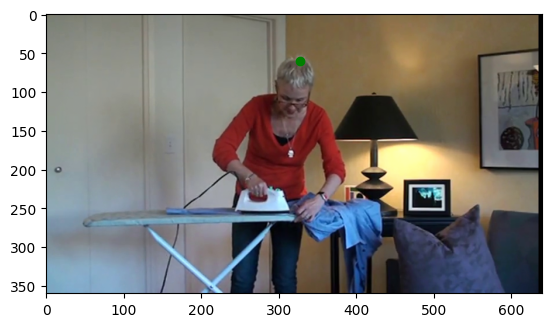

In [240]:
# Show a image from our dataset with the annotations
import matplotlib.pyplot as plt

def show_image(img, points, prediction = None):
    fig, ax = plt.subplots()
    ax.imshow(img)

    height, width, depth = img.shape

    x = [i[0] * width for i in points]
    y = [i[1] * height for i in points]
    plt.plot(x, y, "go")
    if prediction is not None:
        x_pred = [i[0] * width for i in prediction]
        y_pred = [i[1] * height for i in prediction]
        plt.plot(x_pred, y_pred, "ro")
    plt.show()
    
idx = np.random.randint(0, len(images))
show_image(images[idx]["image"], images[idx]["joints"])

In [272]:
from tensorflow import keras
from keras import layers

REG_STRENGTH = 0.01

inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))

head = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(inputs)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(head)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.Conv2D(filters=128, kernel_size=2, padding="same", activation="relu", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(head)
head = layers.MaxPool2D(pool_size=2, strides=2)(head)
head = layers.GlobalMaxPool2D()(head)
head = layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(head)
head = layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(head)

outputs = layers.Dense(2, activation="softmax", kernel_regularizer=keras.regularizers.L2(REG_STRENGTH), bias_regularizer=keras.regularizers.L2(REG_STRENGTH))(head)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 360, 640, 3)]     0         
                                                                 
 conv2d_59 (Conv2D)          (None, 360, 640, 512)     14336     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 180, 320, 512)    0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 180, 320, 256)     1179904   
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 90, 160, 256)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 90, 160, 128)      131

In [273]:
# Split the test data into train/test splits

x = [i["image"] for i in images]
y = [i["joints"] for i in images]

TRAIN_SIZE = 0.75

# TODO: Randomize selection
idx = int(np.floor(TRAIN_SIZE * len(x)))
y_train = np.array(y[:idx])
y_test = np.array(y[idx:])
X_train = np.array(x[:idx])
X_test = np.array(x[idx:])
print("Done")

Done


In [252]:
print(X_train.shape)
print(y_train.shape)

(750, 360, 640, 3)
(750, 1, 2)


In [274]:
# Train the model
model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(), metrics=["acc"])
model.fit(X_train, y_train, batch_size=64, epochs=1, verbose=2)

In [254]:
# Test
test_scores = model.evaluate(X_test, y_test)
print(f"Test loss: {test_scores[0]}")
print(f"Test accuracy: {test_scores[1]}")

8/8 [==============================] - 7s 879ms/step - loss: 1.0863 - acc: 0.8000
Test loss: 1.0863406658172607
Test accuracy: 0.800000011920929


[[0.74172141 0.19472213]]
tf.Tensor([[0.60034597 0.399654  ]], shape=(1, 2), dtype=float32)


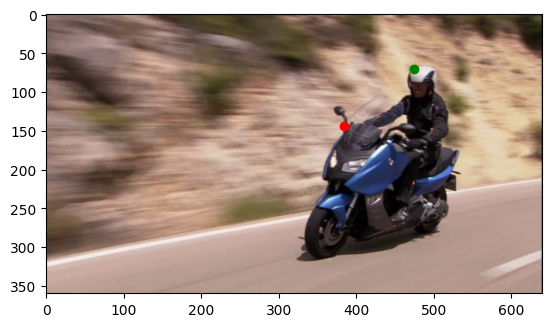

In [270]:
# Visualize a test point
idx = np.random.randint(0, len(X_test))
img = X_test[idx]
prediction = model(np.expand_dims(img, axis=0))
print(y_test[idx])
print(prediction)
show_image(img, y_test[idx], prediction)